In [118]:
%reset

In [119]:
# Notes:
# Leaving outliers in the data produce a larger error
# Leaving incomplete features -- small error increase
# Removing only utilities -- small error increase (leaving incomplete features increase the error as well)
# Increasing incompleteness threshold to 0.2 (Fence being excluded) increases the error
# Decreasing the threshold to 0.5 -- increase in error
# 0.15 seems like an optimal threshold
# Removed new engineered features -- increase in error

# TODO: try removing more outliers
# New batch of outlier: 690, 1181 -- test error improved, but kaggle score got worse. Investigate more once more advanced model is built.
# Play with feature skewness threshold

In [120]:
%load_ext autoreload
%autoreload 2

import sys
import sklearn
import sklearn.decomposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats
import util
import sklearn.preprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Retrieval

In [121]:
train_raw = pd.read_csv('data/train.csv')#, keep_default_na=False)
test_raw = pd.read_csv('data/test.csv')#, keep_default_na=False)

train_y = train_raw['SalePrice']

## 2. Outlier handling

In [122]:
# Let's remove outliers 523 and 1298
train_raw = train_raw.drop([523, 1298]).reset_index(drop=True)
train_y = train_y.drop([523, 1298]).reset_index(drop=True).values
#print(train_raw[train_raw['SalePrice'] > 700000]['Id'])

# # More outliers -- 691 and 1182
# train_raw = train_raw.drop([690, 1181]).reset_index(drop=True)
# train_y = train_y.drop([690, 1181]).reset_index(drop=True)
# print(train_raw[train_raw['SalePrice'] > 700000]['Id'])

# Combine train and test before making any feature changes
data = pd.concat([train_raw, test_raw], axis='rows', sort=False, ignore_index=True)

In [123]:
data['SalePrice']

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
5       143000.0
6       307000.0
7       200000.0
8       129900.0
9       118000.0
10      129500.0
11      345000.0
12      144000.0
13      279500.0
14      157000.0
15      132000.0
16      149000.0
17       90000.0
18      159000.0
19      139000.0
20      325300.0
21      139400.0
22      230000.0
23      129900.0
24      154000.0
25      256300.0
26      134800.0
27      306000.0
28      207500.0
29       68500.0
          ...   
2887         NaN
2888         NaN
2889         NaN
2890         NaN
2891         NaN
2892         NaN
2893         NaN
2894         NaN
2895         NaN
2896         NaN
2897         NaN
2898         NaN
2899         NaN
2900         NaN
2901         NaN
2902         NaN
2903         NaN
2904         NaN
2905         NaN
2906         NaN
2907         NaN
2908         NaN
2909         NaN
2910         NaN
2911         NaN
2912         NaN
2913         NaN
2914         N

## 3. Feature Cleanup

In [124]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit_transform(data['MoSold'].astype(str).values)

array([ 4,  7, 11, ..., 11,  9,  2], dtype=int64)

In [125]:
# Let's separate features into categorical (ordinal and nominal) and numerical features
numerical_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 
                      'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                      '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                      'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                      'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
                      'OverallQual', 'OverallCond', 'MiscVal', 'MoSold'] # Last row of features could be considered categorical

# Manually define ordinal features
ordinal_features = ['MSSubClass', 'LotShape', 'LandContour', 'LotConfig',
                    'LandSlope', 'BldgType', 'HouseStyle', 'ExterQual',
                    'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                    'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
                    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
                    'Fence', 'Utilities', 'YearBuilt', 'YearRemodAdd', 
                    'GarageYrBlt', 'YrSold', 'Street']

# Categorical nominal features are what's left
all_features = list(data.columns.values)
all_features.remove('Id')
all_features.remove('SalePrice')

nominal_features = [f for f in all_features if f not in numerical_features + ordinal_features]

In [126]:
# Let's rename mislabeled rows
util.replace_with(data=data, feature_name='BldgType', value_to_replace='Duplex', new_value='Duplx')
util.replace_with(data=data, feature_name='BldgType', value_to_replace='2fmCon', new_value='2FmCon')
# There's 'Twnhs', which should stand for a Townhouse, but the value is missing from data_description.txt
# Since there are no records for TwnhsE, let's rename Twnhs fields to match the data description
util.replace_with(data=data, feature_name='BldgType', value_to_replace='Twnhs', new_value='TwnhsI')

In [127]:
# Convert MSSubClass from int to string before making mapping
data['MSSubClass'] = data['MSSubClass'].astype('str')

## 4. Feature Removal

In [128]:
feature_completeness = data.apply(util.completeness, axis='rows').sort_values()
feature_completeness

PoolQC           0.003085
MiscFeature      0.035996
Alley            0.067878
Fence            0.195749
SalePrice        0.499829
FireplaceQu      0.513198
LotFrontage      0.833390
GarageFinish     0.945492
GarageQual       0.945492
GarageCond       0.945492
GarageYrBlt      0.945492
GarageType       0.946178
BsmtCond         0.971889
BsmtExposure     0.971889
BsmtQual         0.972232
BsmtFinType2     0.972575
BsmtFinType1     0.972917
MasVnrType       0.991772
MasVnrArea       0.992115
MSZoning         0.998629
BsmtFullBath     0.999314
BsmtHalfBath     0.999314
Functional       0.999314
Utilities        0.999314
KitchenQual      0.999657
BsmtFinSF1       0.999657
BsmtFinSF2       0.999657
Electrical       0.999657
TotalBsmtSF      0.999657
BsmtUnfSF        0.999657
                   ...   
GrLivArea        1.000000
MSSubClass       1.000000
LotArea          1.000000
Street           1.000000
LotShape         1.000000
LandContour      1.000000
LotConfig        1.000000
LandSlope   

Alley
Grvl                 120
NaN_count_unique    2719
Pave                  78
Name: Id, dtype: int64


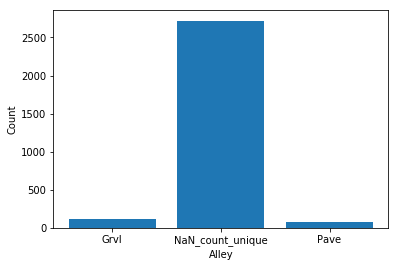

---------------------------------------


In [129]:
# Find out how
#for f in data.columns.drop(['Id']):
for f in ['Alley']:
    unique = util.count_unique(data=data, feature_name=f)
    print(unique)

    # if there is NA label among numerical values, we have a problem with matplotlib
    if type(unique.index[0]) is float:
        unique = unique.rename(index={'NA': -1})
    
    x = list(unique.index)
    y = list(unique)
    
    if len(x) > 100:
        plt.scatter(x=x, y=y, marker='.', s=10)
    else:
        fig, ax = plt.subplots()
        ax.bar(x, y)#, tick_label=['ulu'])
        #ax.set_xticklabels(('G1', 'G2', 'G3'))
    plt.xlabel(f)
    plt.ylabel('Count')
    plt.show()
    
    print('---------------------------------------')

In [130]:
# Find features that are less than 15% complete (reconsider the threshold)
completeness_threshold = 0.15
features_below_threshold = feature_completeness.loc[feature_completeness < completeness_threshold].index.values

# Exclude SalePrice
if 'SalePrice' in features_below_threshold:
    features_below_threshold = features_below_threshold.drop(['SalePrice'])
    
# Remove features below completeness threshold from the original data
data = data.drop(features_below_threshold, axis='columns')

print('Removed features: ')
print(features_below_threshold)

Removed features: 
['PoolQC' 'MiscFeature' 'Alley']


In [131]:
# Remove Utilities since there are only 2 records which have difference values other than AllPub
data = data.drop('Utilities', axis='columns')
ordinal_features.remove('Utilities')

In [132]:
# Remove deleted features from feature lists
removed_features = list(features_below_threshold)
for f in removed_features:
    if f in numerical_features:
        numerical_features.remove(f)
    elif f in ordinal_features:
        ordinal_features.remove(f)
    else:
        nominal_features.remove(f)

## 5. Categorical Feature Handling

In [133]:
# This dictionary will store items in decreasing order
ordinal_features_order_desc = {}

# Street and Alley (gravel, paved) can be ordinal, but let's leave them as nominal
ordinal_features_order_desc['LotShape'] = 'Reg IR1 IR2 IR3'
# Let's assume that any categorical feature with 2 possible values can be considered ordinal
ordinal_features_order_desc['Street'] = 'Grvl Pave'
ordinal_features_order_desc['LandContour'] = 'Lvl Bnk HLS Low'
# Seems like an ordinal feature, but it's unclear what is better
ordinal_features_order_desc['LotConfig'] = 'Inside Corner CulDSac FR2 FR3'
ordinal_features_order_desc['LandSlope'] = 'Gtl Mod Sev'
# Order is not clear
ordinal_features_order_desc['BldgType'] = '1Fam 2FmCon Duplx TwnhsE TwnhsI Twnhs'
# Order is not clear
ordinal_features_order_desc['HouseStyle'] = '1Story 1.5Fin 1.5Unf 2Story 2.5Fin 2.5Unf SFoyer SLvl'
ordinal_features_order_desc['ExterQual'] = 'Ex Gd TA Fa Po'
ordinal_features_order_desc['ExterCond'] = 'Ex Gd TA Fa Po'
ordinal_features_order_desc['BsmtQual'] = 'Ex Gd TA Fa Po NaN'
ordinal_features_order_desc['BsmtCond'] = 'Ex Gd TA Fa Po NaN'
ordinal_features_order_desc['BsmtExposure'] = 'Gd Av Mn No NaN'
ordinal_features_order_desc['BsmtFinType1'] = 'GLQ ALQ BLQ Rec LwQ Unf NaN'
ordinal_features_order_desc['BsmtFinType2'] = 'GLQ ALQ BLQ Rec LwQ Unf NaN'
ordinal_features_order_desc['HeatingQC'] = 'Ex Gd TA Fa Po'
ordinal_features_order_desc['KitchenQual'] = 'Ex Gd TA Fa Po'
ordinal_features_order_desc['Functional'] = 'Typ Min1 Min2 Mod Maj1 Maj2 Sev Sal'
ordinal_features_order_desc['FireplaceQu'] = 'Ex Gd TA Fa Po NaN'
ordinal_features_order_desc['GarageType'] = '2Types Attchd Basment BuiltIn CarPort Detchd NaN'
ordinal_features_order_desc['GarageFinish'] = 'Fin RFn Unf NaN'
ordinal_features_order_desc['GarageQual'] = 'Ex Gd TA Fa Po NaN'
ordinal_features_order_desc['GarageCond'] = 'Ex Gd TA Fa Po NaN'
ordinal_features_order_desc['PavedDrive'] = 'Y P N'
ordinal_features_order_desc['MSSubClass'] = '20 30 40 45 50 60 70 75 80 85 90 120 150 160 180 190'
ordinal_features_order_desc['Fence'] = 'GdPrv MnPrv GdWo MnWw NaN'

# These features got removed, let's keep this in case feature removal negatively affects model accuracy
ordinal_features_order_desc['PoolQC'] = 'Ex Gd TA Fa NaN'
ordinal_features_order_desc['Alley'] = 'Grvl Pave NaN'
ordinal_features_order_desc['Utilities'] = 'AllPub NoSewr NoSeWa ELO'

In [134]:
numerical_from_ordinal = data[ordinal_features]
for feature in ordinal_features:
    if feature not in ordinal_features_order_desc:
        encoder = sklearn.preprocessing.LabelEncoder()
        numerical_from_ordinal[feature] = encoder.fit_transform(data[feature])
        continue
    
    numerical_from_ordinal[feature] = util.ordinal_to_numerical(
        data=data, 
        feature_name=feature, 
        order_str=ordinal_features_order_desc[feature])

# Rewrite the ordinal features with numeric values
data[ordinal_features] = numerical_from_ordinal

In [135]:
# Create dummy variables out of nominal features
dummies = pd.get_dummies(data[nominal_features[0]], prefix=nominal_features[0], drop_first=True)
for i in range(1, len(nominal_features)):
    print(nominal_features[i])
    new_dummies = pd.get_dummies(data[nominal_features[i]], prefix=nominal_features[i], drop_first=True)
    dummies = pd.concat([dummies, new_dummies], axis='columns')
    
nominal_dummy_features = list(dummies.columns)
    
# Remove the original nominal features
data = data.drop(nominal_features, axis='columns')
# Assign new dummy variables to original data
data[nominal_dummy_features] = dummies

Neighborhood
Condition1
Condition2
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
Foundation
Heating
CentralAir
Electrical
SaleType
SaleCondition


## 6. Zero and NaN 

In [136]:
# Let's investigate specific feature groups and try to fill missing values
for f in (numerical_features + ordinal_features):
    util.count_nans_and_zeros(data, f)
    
# TODO find out what happened to nans in numerical features when reading csv

LotFrontage          NaNs: 486  Zeros: 0   
LotArea              NaNs: 0    Zeros: 0   
MasVnrArea           NaNs: 23   Zeros: 1738
BsmtFinSF1           NaNs: 1    Zeros: 929 
BsmtFinSF2           NaNs: 1    Zeros: 2569
BsmtUnfSF            NaNs: 1    Zeros: 241 
TotalBsmtSF          NaNs: 1    Zeros: 78  
1stFlrSF             NaNs: 0    Zeros: 0   
2ndFlrSF             NaNs: 0    Zeros: 1668
LowQualFinSF         NaNs: 0    Zeros: 2877
GrLivArea            NaNs: 0    Zeros: 0   
BsmtFullBath         NaNs: 2    Zeros: 1705
BsmtHalfBath         NaNs: 2    Zeros: 2740
FullBath             NaNs: 0    Zeros: 12  
HalfBath             NaNs: 0    Zeros: 1834
BedroomAbvGr         NaNs: 0    Zeros: 8   
KitchenAbvGr         NaNs: 0    Zeros: 3   
TotRmsAbvGrd         NaNs: 0    Zeros: 0   
Fireplaces           NaNs: 0    Zeros: 1420
GarageCars           NaNs: 1    Zeros: 157 
GarageArea           NaNs: 1    Zeros: 157 
WoodDeckSF           NaNs: 0    Zeros: 1523
OpenPorchSF          NaNs: 0    

In [137]:
# Fill zeros
zero_cols_numerical = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']

zero_cols_categorical = ['GarageCars', 'GarageArea']#, 'BathNumSum']

data[zero_cols_numerical + zero_cols_categorical] = data[zero_cols_numerical + zero_cols_categorical].fillna(0)

In [138]:
#util.describe_feature(data=data[:len(train_data)], feature_name='BsmtQual', is_categorical=True, plot_outliers=True, y=train_y)

## 7. Feature Engineering

In [139]:
# New features: SoldNew, BathNumSum, AgeWhenSoldTotal, AgeWhenSoldRemod
data['SoldNew'] = np.where(data['YearBuilt'] == data['YearRemodAdd'], 1, 0)

# Bath features: 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
data['BathNumSum'] = data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath'] + data['FullBath'] + 0.5 * data['HalfBath']
data['AgeWhenSoldTotal'] = data['YrSold'] - data['YearBuilt']
data['AgeWhenSoldRemod'] = data['YrSold'] - data['YearRemodAdd']
data['TotalPorchSF'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']

new_features = ['SoldNew', 'BathNumSum', 'AgeWhenSoldTotal', 'AgeWhenSoldRemod', 'TotalPorchSF']
numerical_features = numerical_features + new_features

In [140]:
#data[['YearBuilt', 'YearRemodAdd', 'SoldNew']]
#data[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BathNumSum']]
#data[['YrSold', 'YearBuilt', 'YearRemodAdd', 'AgeWhenSoldTotal', 'AgeWhenSoldRemod']]

In [141]:
import itertools

# Let's experiment with combined features
# Define two sets: set of features to be combined with each other and set of functions to combine with
functions = {'add': lambda data, x: data[x[0]] + data[x[1]], 'mult': lambda data, x: data[x[0]] * data[x[1]]}
features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars',
            'BathNumSum', 'BathNumSum', '1stFlrSF', 'GarageArea', 'FullBath',
            'TotRmsAbvGrd']
# Use itertools.permutations(features, 2) when functions are not symmetrical f(a,b) != f(b,a)
features_permuted = list(itertools.combinations(features, 2)) 
data_new = pd.DataFrame()
for feat_perm in features_permuted:
    for func in functions:
        new_feature_name = '{}_{}_{}'.format(feat_perm[0], func, feat_perm[1])
        data_new[new_feature_name] = functions[func](data, feat_perm)

auto_features = list(data_new.columns)
data_new['SalePrice'] = data['SalePrice']
        
# TODO standartize features before applying functions

In [142]:
# Add quadratic and qubic features
# TODO refactor how new_features list is maintained
pow_features = []
for feature in features:
    feature_pow2_name = '{}_pow2'.format(feature)
    feature_pow3_name = '{}_pow3'.format(feature)
    
    pow_features.append(feature_pow2_name)
    pow_features.append(feature_pow3_name)
    
    data_new[feature_pow2_name] = data[feature] * data[feature]
    data_new[feature_pow3_name] = data[feature] * data[feature] * data[feature]

In [143]:
train_data_new, test_data_new = data_new[:len(train_raw)], data_new[len(train_raw):].reset_index(drop=True)

OverallQual_mult_GrLivArea       0.874116
OverallQual_pow3                 0.835829
OverallQual_add_BathNumSum       0.832521
GrLivArea_mult_TotalBsmtSF       0.829176
GrLivArea_add_TotalBsmtSF        0.829042
OverallQual_mult_1stFlrSF        0.827169
GrLivArea_mult_GarageCars        0.825324
OverallQual_pow2                 0.824582
OverallQual_mult_BathNumSum      0.822308
OverallQual_add_GarageCars       0.819719
OverallQual_mult_TotalBsmtSF     0.817632
OverallQual_mult_GarageCars      0.812820
GrLivArea_mult_GarageArea        0.812334
OverallQual_mult_TotRmsAbvGrd    0.810382
OverallQual_add_FullBath         0.807222
OverallQual_mult_GarageArea      0.803856
GrLivArea_add_GarageArea         0.799983
TotalBsmtSF_mult_BathNumSum      0.786885
GrLivArea_add_1stFlrSF           0.786506
GrLivArea_mult_BathNumSum        0.783829
GrLivArea_mult_1stFlrSF          0.780916
TotalBsmtSF_mult_GarageCars      0.780430
BathNumSum_mult_GarageArea       0.778237
OverallQual_add_TotRmsAbvGrd     0

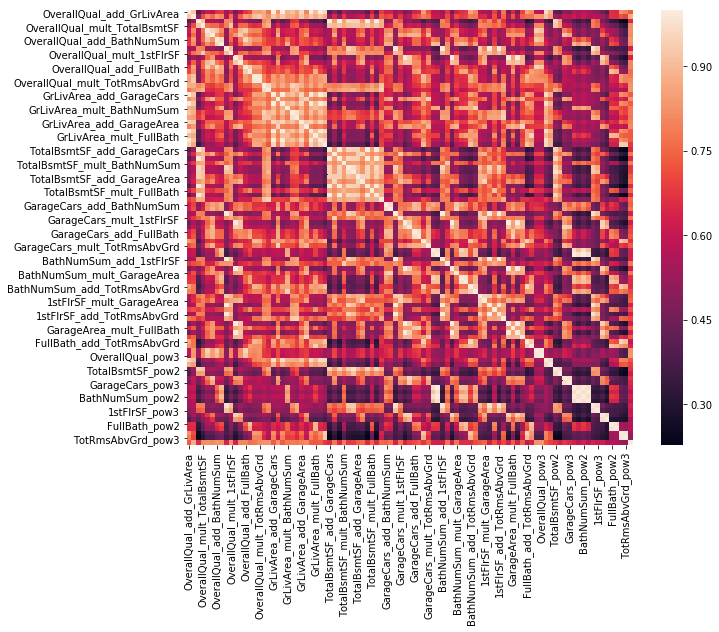

In [144]:
new_features_corr = util.corr_map(train_data_new, auto_features + pow_features)
new_features_corr

In [145]:
# Add top 10 generated features to the list
top_auto_features = new_features_corr[:10].index.values
data[top_auto_features] = data_new[top_auto_features]
numerical_features = numerical_features + list(top_auto_features)

## 8. Feature Plotting

In [146]:
# Since we're plotting data against SalePrice, we need to use train data and abandon test data
train_data, test_data = data[:len(train_raw)], data[len(train_raw):].reset_index(drop=True)

In [147]:
# for f in numerical_features:
#     util.plot_feature(train_raw, f, train_y, plot_outliers=True)

In [148]:
# for f in ordinal_features:
#     util.plot_feature(numerical_from_ordinal, f, train_y)

In [149]:
# for f in new_features:
#     util.plot_feature_with_outliers(data=train_raw, feature_name=f, prices=train_raw['SalePrice'])

OverallQual_mult_GrLivArea     0.874116
OverallQual_pow3               0.835829
OverallQual_add_BathNumSum     0.832521
GrLivArea_mult_TotalBsmtSF     0.829176
GrLivArea_add_TotalBsmtSF      0.829042
OverallQual_mult_1stFlrSF      0.827169
GrLivArea_mult_GarageCars      0.825324
OverallQual_pow2               0.824582
OverallQual_mult_BathNumSum    0.822308
OverallQual_add_GarageCars     0.819719
OverallQual                    0.795774
GrLivArea                      0.734968
TotalBsmtSF                    0.651153
GarageCars                     0.641047
BathNumSum                     0.635896
1stFlrSF                       0.631530
GarageArea                     0.629217
FullBath                       0.562165
TotRmsAbvGrd                   0.537769
AgeWhenSoldTotal               0.533493
AgeWhenSoldRemod               0.509706
MasVnrArea                     0.477810
Fireplaces                     0.469862
BsmtFinSF1                     0.409384
WoodDeckSF                     0.324758


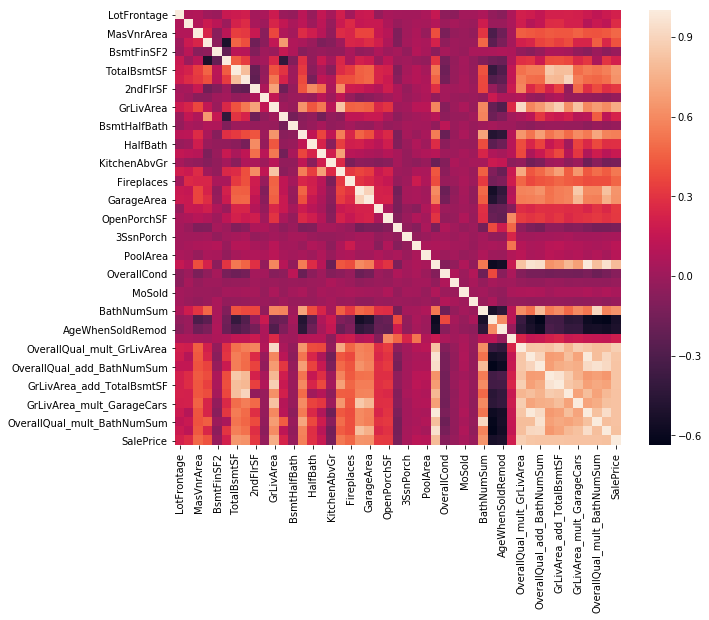

In [150]:
features_corr = util.corr_map(train_data, numerical_features)
features_corr

In [151]:
# for feature in features_corr.index:
#     print('Feature: {} Correlation: {}'.format(feature, features_corr[feature]))
#     util.describe_feature(train_data, feature, train_y, is_categorical=feature in [ordinal_features + nominal_features], plot_outliers=True)

## Feature Selection by Feature Importance Criteria

In [285]:
features_to_select = numerical_features + new_features + ordinal_features
rf_feature_selection = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=2000, max_features=len(features_to_select))
# We can't use categorical data to estimate the feature importance, so let's use only numeriacl ones
rf_feature_selection.fit(X=train_data[features_to_select].values, y=train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=80, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [286]:
importances = dict(zip(features_to_select, rf_feature_selection.feature_importances_))
sorted_importances = sorted(importances.items(), key=operator.itemgetter(1), reverse=True)
sorted_importances

[('OverallQual_mult_GrLivArea', 0.4324229172671894),
 ('OverallQual_add_BathNumSum', 0.23618724264144442),
 ('OverallQual_add_GarageCars', 0.14885759881313979),
 ('GrLivArea_add_TotalBsmtSF', 0.04306051390415141),
 ('OverallQual_mult_1stFlrSF', 0.04116458357851121),
 ('GrLivArea_mult_TotalBsmtSF', 0.03941020996563149),
 ('OverallQual_mult_BathNumSum', 0.022024289827971326),
 ('GrLivArea_mult_GarageCars', 0.020711137330083642),
 ('TotalBsmtSF', 0.0037312589222341292),
 ('BsmtFinSF1', 0.0023723115817143653),
 ('2ndFlrSF', 0.0017365095572882386),
 ('GrLivArea', 0.0016774407243229825),
 ('BsmtQual', 0.0014542592058495872),
 ('OverallQual_pow2', 0.0008990138007207488),
 ('TotRmsAbvGrd', 0.0004555086201549021),
 ('KitchenQual', 0.00040081938879744363),
 ('OverallQual', 0.0003258450524634666),
 ('LotArea', 0.0002634931391568891),
 ('MoSold', 0.0002476796475737868),
 ('FullBath', 0.0002464739046844743),
 ('LotFrontage', 0.00024340952165778317),
 ('YearBuilt', 0.00023161274226283617),
 ('MasVnr

## 9. Feature Skewness

In [152]:
features_skewness = data[numerical_features].apply(lambda x: scipy.stats.skew(x), axis='rows')
features_skewness = features_skewness[features_skewness.abs().sort_values(ascending=False).index]
features_skewness

MiscVal                        21.939672
SoldNew                        17.919660
PoolArea                       17.688664
LotArea                        13.109495
LowQualFinSF                   12.084539
3SsnPorch                      11.372080
GrLivArea_mult_TotalBsmtSF      4.546044
KitchenAbvGr                    4.300550
BsmtFinSF2                      4.144503
EnclosedPorch                   4.002344
ScreenPorch                     3.945101
BsmtHalfBath                    3.929996
MasVnrArea                      2.621719
OpenPorchSF                     2.529358
TotalPorchSF                    2.244500
OverallQual_mult_1stFlrSF       1.856957
WoodDeckSF                      1.844792
OverallQual_mult_GrLivArea      1.512803
OverallQual_pow3                1.396542
1stFlrSF                        1.257286
GrLivArea_mult_GarageCars       1.237808
GrLivArea                       1.068750
GrLivArea_add_TotalBsmtSF       1.011805
BsmtFinSF1                      0.980645
BsmtUnfSF       

In [153]:
# Find features with skewness > 0.8
skewed_features = features_skewness[features_skewness.abs() > 0.8]
# log(feature + 1) operation. +1 allows to avoid division by zero.
log_train_data_numerical = np.log(train_data[skewed_features.index] + 1)
nonskewed_features = [x for x in numerical_features if x not in skewed_features]

In [154]:
# for f in features_skewness.index:
#     print('Feature: {} Skewness: {}'.format(f, features_skewness[f]))
#     sns.distplot(train_data[f])
#     plt.show()
    
#     sns.distplot(log_train_data_numerical[f])
#     plt.show()

In [155]:
scaled_features = (log_train_data_numerical - log_train_data_numerical.mean()) / log_train_data_numerical.std()

## 10. Feature Scaling

In [156]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [157]:
# Split train and test data before normaization
# Select only the variables we intend to use for training
data_to_scale = data[numerical_features + ordinal_features + nominal_dummy_features]
train_data, test_data = data_to_scale[:len(train_raw)], data_to_scale[len(train_raw):]

In [158]:
standard_scaler = StandardScaler()
train_data_std = standard_scaler.fit_transform(train_data)
test_data_std = standard_scaler.transform(test_data)

robust_scaler = RobustScaler()
train_data_rob = robust_scaler.fit_transform(train_data)
test_data_rob = robust_scaler.transform(test_data)

train_mean = train_data.mean()
train_std = train_data.std()

# Standardize test data by train mean and deviation
train_data_man = (train_data - train_mean) / train_std
test_data_man = (test_data - train_mean) / train_std

# # There's no point in standardizing the dummy variables, so use it only for numerical and ordinal features
# features = numerical_features + ordinal_features
# data[features] = (data[features] - data[features].mean()) / data[features].std()

## 11. Modeling

In [180]:
from sklearn.linear_model import ElasticNet, Lasso, LassoCV, BayesianRidge, LassoLarsIC, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
import xgboost as xgb
import lightgbm as lgb

In [185]:
def score_cv(model, x, y, n_folds=5):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=n_folds))
    return rmse.mean(), rmse.std()

model_scores = {}

In [161]:
warnings.filterwarnings(action='ignore')

# Lasso Regression
param_grid_lasso = [{'alpha':[490]}]
gs_lasso = GridSearchCV(estimator=Lasso(), param_grid=param_grid_lasso, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
gs_lasso.fit(X=train_data_std, y=train_y)
print(gs_lasso.best_params_)

# param_dist_lasso = {'alpha': uniform(loc=0, scale=0.005)}
# gs_lasso = RandomizedSearchCV(estimator=Lasso(), param_distributions=param_dist_lasso, scoring='neg_mean_squared_error', cv=5, n_iter=1000)
# gs_lasso.fit(X=train_data_std, y=train_y)
# print(gs_lasso.best_params_)

lasso = gs_lasso.best_estimator_
lasso_score = score_cv(lasso, x=train_data_std, y=train_y, n_folds=5)
print('Lasso Final Test Score: {}'.format(lasso_score))
model_scores['lasso'] = lasso_score

{'alpha': 490}
Lasso Final Test Score: (22609.113974688902, 1586.1122393406126)


In [162]:
# Ridge Regression
param_grid_ridge = [{'alpha': [117.61]}]
gs_ridge = GridSearchCV(estimator=Ridge(), param_grid=param_grid_ridge, cv=5, return_train_score=True)
gs_ridge.fit(X=train_data_std, y=train_y)
print(gs_ridge.best_params_)

# param_dist_ridge = {'alpha': uniform(loc=8, scale=8.5)}
# gs_ridge = RandomizedSearchCV(estimator=Ridge(), 
#                               param_distributions=param_dist_ridge, scoring='neg_mean_squared_error', cv=5, n_iter=1000, verbose=1)
# gs_ridge.fit(X=train_data_std, y=train_y)
# print(gs_ridge.best_params_)

ridge = gs_ridge.best_estimator_
ridge_score = score_cv(ridge, x=train_data_std, y=train_y, n_folds=5)
print('Ridge Final Test Score: {}'.format(ridge_score))    
model_scores['ridge'] = ridge_score

{'alpha': 117.61}
Ridge Final Test Score: (23406.70925369516, 1811.0006053015757)


In [163]:
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

# Elastic Net Regression
param_grid_enet = {'alpha': [1.1], #[500, 515, 520], 
                   'l1_ratio': [0.9],
                   'max_iter': [1000]}
gs_enet = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid_enet, cv=5, return_train_score=True)
gs_enet.fit(X=train_data_std, y=train_y)

# param_dist_enet = {'alpha': uniform(loc=0.005, scale=0.002), 
#                    'l1_ratio': uniform(loc=0.5, scale=0.1),
#                    'max_iter': [1000]}
# gs_enet = RandomizedSearchCV(estimator=ElasticNet(), 
#                              param_distributions=param_dist_enet, cv=5, return_train_score=True, n_iter=1000, verbose=1)#, n_jobs=-1)
# gs_enet.fit(X=train_data_std, y=train_y)

print(gs_enet.best_params_)

enet = gs_enet.best_estimator_
enet_score = score_cv(enet, x=train_data_std, y=train_y, n_folds=5)
print('Elastic Net Final Test Score: {}'.format(enet_score))
model_scores['enet'] = enet_score

{'alpha': 1.1, 'l1_ratio': 0.9, 'max_iter': 1000}
Elastic Net Final Test Score: (23438.226132670305, 1846.2374378193651)


In [164]:
# Kernel Ridge Regression
param_grid_kridge = {'alpha': [0.4538],
                     'kernel': ['polynomial'],
                     'degree': [2],
                     'coef0': [0.66]}
gs_kridge = GridSearchCV(estimator=KernelRidge(), param_grid=param_grid_kridge, cv=5, return_train_score=True)
gs_kridge.fit(X=train_data_std, y=train_y)
print(gs_kridge.best_params_)

# param_dist_kridge = {'alpha': uniform(loc=1.5, scale=0.3),
#                      'kernel': ['polynomial'],
#                      'degree': [2],
#                      'coef0': uniform(loc=3, scale=3.2)}
# gs_kridge = RandomizedSearchCV(estimator=KernelRidge(), 
#                                param_distributions=param_dist_kridge, scoring='neg_mean_squared_error', cv=5, n_iter=1000, verbose=1)
# gs_kridge.fit(X=train_data_std, y=train_y)
# print(gs_kridge.best_params_)

kridge = gs_kridge.best_estimator_
kridge_score = score_cv(kridge, x=train_data_std, y=train_y, n_folds=5)
print('Ridge Final Test Score: {}'.format(kridge_score))
model_scores['kridge'] = kridge_score

{'alpha': 0.4538, 'coef0': 0.66, 'degree': 2, 'kernel': 'polynomial'}
Ridge Final Test Score: (20090.18751338892, 1150.7448870600426)


In [165]:
param_grid_gboost = {'n_estimators': [4650],
                     'learning_rate': [0.05],
                     'max_depth': [2],
                     'max_features': ['sqrt'],
                     'min_samples_leaf': [10],
                     'min_samples_split': [10],
                     'loss': ['huber']}
gs_gboost = GridSearchCV(estimator=GradientBoostingRegressor(), 
                         param_grid=param_grid_gboost, scoring='neg_mean_squared_error', cv=5, return_train_score=True, verbose=1)
gs_gboost.fit(X=train_data_std, y=train_y)
print(gs_gboost.best_params_)

# param_dist_gboost = {'n_estimators': [4650], 'learning_rate': [0.05],
#                      'max_depth': [2], 'max_features': ['sqrt'],
#                      'min_samples_leaf': [10], 'min_samples_split': [10],
#                      'loss': ['huber']}
# gs_gboost = RandomizedSearchCV(estimator=GradientBoostingRegressor(), 
#                                param_distributions=param_dist_kridge, scoring='neg_mean_squared_error', cv=5, n_iter=100, verbose=1)
# gs_gboost.fit(X=train_data_std, y=train_y)
# print(gs_gboost.best_params_)

gboost = gs_gboost.best_estimator_
gboost_score = score_cv(gboost, x=train_data_std, y=train_y, n_folds=5)
print('Gradient Boost Final Test Score: {}'.format(gboost_score))
model_scores['gboost'] = gboost_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.2s finished


{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 4650}
Gradient Boost Final Test Score: (21335.78153126404, 2643.405020762751)


In [166]:
param_grid_lgb = {
    'objective': ['regression'], 'num_leaves': [4],
    'learning_rate': [0.05], 'n_estimators': [2100],
    'max_bin': [55], 'bagging_fraction': [0.85],
    'bagging_freq': [5], 'feature_fraction': [0.2319],
    'feature_fraction_seed': [9], 'bagging_seed': [9],
    'min_data_in_leaf': [9], 'min_sum_hessian_in_leaf': [11]
}
gs_lgb = GridSearchCV(estimator=lgb.LGBMRegressor(), 
                      param_grid=param_grid_lgb, scoring='neg_mean_squared_error', cv=5, return_train_score=True, verbose=1)
gs_lgb.fit(X=train_data_std, y=train_y)
print(gs_lgb.best_params_)

lgb_model = gs_lgb.best_estimator_
lgb_score = score_cv(lgb_model, x=train_data_std, y=train_y, n_folds=5)
print('LGB Final Score: {}'.format(lgb_score))
model_scores['lgb_model'] = lgb_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


{'bagging_fraction': 0.85, 'bagging_freq': 5, 'bagging_seed': 9, 'feature_fraction': 0.2319, 'feature_fraction_seed': 9, 'learning_rate': 0.05, 'max_bin': 55, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 11, 'n_estimators': 2100, 'num_leaves': 4, 'objective': 'regression'}
LGB Final Score: (21755.024916340335, 2176.5815393290286)


In [171]:
# param_grid_xgb = {'colsample_bytree': [0.11577089219916092], 'gamma': [0.3628046053873214], 
#                   'learning_rate': [0.05359696766901079], 'max_depth': [2], 
#                   'min_child_weight': [0.00896821636132572], 'n_estimators': [1000], 
#                   'n_jobs': [-1], 'random_state': [7], 
#                   'reg_alpha': [0.8595036336304563], 'reg_lambda': [0.2103419052497537], 
#                   'silent': [1], 'subsample': [0.7635066245330188]}
param_grid_xgb = {'colsample_bytree': [0.4603], 'gamma': [0.0468], 
                  'learning_rate': [0.05], 'max_depth': [2], 
                  'min_child_weight': [1.7817], 'n_estimators': [1200], 
                  'reg_alpha': [0.4640], 'reg_lambda': [0.8571], 
                  'subsample': [0.5213], 'silent': [1],
                  'n_jobs': [-1], 'random_state': [7]}
gs_xgb = GridSearchCV(estimator=xgb.XGBRegressor(), 
                      param_grid=param_grid_xgb, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
gs_xgb.fit(X=train_data_std, y=train_y)
print(gs_xgb.best_params_)

# param_dist_xgb = {'colsample_bytree': [0.11577], 'gamma': [0.3628],
#                   'learning_rate': [0.053], 'max_depth': [2],
#                   'min_child_weight': uniform(loc=0.0, scale=3), 'n_estimators': [1200],
#                   'reg_alpha': [0.8595], 'reg_lambda': [0.21034],
#                   'subsample': [0.7635], 'silent': [1],
#                   'random_state': [7], 'n_jobs': [-1]}
# gs_xgb = RandomizedSearchCV(estimator=xgb.XGBRegressor(), 
#                             param_distributions=param_dist_xgb, scoring='neg_mean_squared_error', cv=5, n_iter=10000, verbose=1, return_train_score=True)
# gs_xgb.fit(X=train_data_std, y=train_y)
# print(gs_xgb.best_params_)

xgb_model = gs_xgb.best_estimator_
xgb_score = score_cv(xgb_model, x=train_data_std, y=train_y, n_folds=5)
print('XGB Final Score: {}'.format(xgb_score))
model_scores['xgb_model'] = xgb_score

{'colsample_bytree': 0.4603, 'gamma': 0.0468, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1.7817, 'n_estimators': 1200, 'n_jobs': -1, 'random_state': 7, 'reg_alpha': 0.464, 'reg_lambda': 0.8571, 'silent': 1, 'subsample': 0.5213}
XGB Final Score: (21660.521634229885, 2368.4616226777716)


In [198]:
# # SVM
# # SVR(kernel='rbf', degree=3, 
# #                 gamma=0.01, coef0=0.0, 
# #                 tol=0.001, C=1.0, 
# #                 epsilon=0.1, shrinking=True, 
# #                 cache_size=200, verbose=False, 
# #                 max_iter=-1)

# # param_grid_svr = {'gamma': [0.001], 'C': [1.0], 'epsilon': [0.2]}
# # gs_svr = GridSearchCV(estimator=SVR(), 
# #                       param_grid=param_grid_svr, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
# # gs_svr.fit(X=train_data_std, y=train_y)
# # print(gs_svr.best_params_)

# param_dist_svr = {'gamma': uniform(loc=0, scale=1),
#                   'C': uniform(loc=0, scale=10),
#                   'epsilon': uniform(loc=0, scale=1)}
# gs_svr = RandomizedSearchCV(estimator=SVR(), 
#                             param_distributions=param_dist_svr, scoring='neg_mean_squared_error', cv=5, n_iter=10, verbose=1, return_train_score=True)
# gs_svr.fit(X=train_data_std, y=train_y)
# print(gs_xgb.best_params_)

# svr_model = gs_svr.best_estimator_
# svr_score = score_cv(svr_model, x=train_data_std, y=train_y, n_folds=5)
# print('SVR Final Score: {}'.format(svr_score))
# model_scores['svr_model'] = svr_score

## Stacked Regressions

In [172]:
class AvgModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [199]:
class StackModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, metamodel, n_folds=5):
#         print('init called')
#         print('models: {}'.format(models))
        self.models = models
        self.metamodel = metamodel
        self.n_folds = n_folds
        self.models_ = None
        self.metamodel_ = None
        
        
    def fit_base(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        self.metamodel_ = clone(self.metamodel)
        # Create empty 2d list for models to be fit
        #print('models: ' + self.models_)
        self.fit_models_ = [[] for m in self.models_]
        
        model_counter = 0
        # Leave one split for overall model score estimation
        base_predictions = np.zeros((X.shape[0], len(self.models_)))
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        for train_index, holdout_index in kfold.split(X, y):
            fold_X, fold_y = X[train_index], list(y[train_index])
            holdout_X = X[holdout_index]
            for model_index, model in enumerate(self.models_):
                model_clone = clone(model)
                self.fit_models_[model_index].append(model_clone)
                model_clone.fit(X=fold_X, y=fold_y)
                base_predictions[holdout_index, model_index] = model_clone.predict(holdout_X)        
        
        return base_predictions
    
        
    def fit(self, X, y):
        base_predictions = self.fit_base(X, y)            
        self.metamodel_.fit(X=base_predictions, y=y)

        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in fit_models]).mean(axis=1)
            for fit_models in self.fit_models_ ])
        return self.metamodel_.predict(meta_features)

In [202]:
avg = AvgModels(models=[xgb_model, kridge, lgb_model])
score_cv(model=avg, x=train_data_std, y=train_y, n_folds=5)

(20154.985466785332, 1842.065265484726)

In [251]:
stack = StackModel(models=[xgb_model, kridge, lgb_model], metamodel=lasso, n_folds=5)
stack_score = score_cv(model=stack, x=train_data_std, y=train_y, n_folds=5)
print('Stack Final Score: {}'.format(stack_score))

Stack Final Score: (21499.295728542696, 2133.960108408546)


## Metamodel Hyperparameter Tuning

In [207]:
# Get the base predictions on the best performing base models
base_predictions = stack.fit_base(X=train_data_std, y=train_y)

In [252]:
# Let's try Kernel Ridge Regression
param_grid_kridge_meta = {'alpha': [7.991548849785877],
                          'kernel': ['polynomial'],
                          'degree': [2],
                          'coef0': [5.787434696648401]}
gs_kridge_meta = GridSearchCV(estimator=KernelRidge(), param_grid=param_grid_kridge_meta, cv=5, return_train_score=True)
gs_kridge_meta.fit(X=base_predictions, y=train_y)
print(gs_kridge_meta.best_params_)

# param_dist_kridge_meta = {'alpha': [7.991548849785877],
#                           'kernel': ['polynomial'],
#                           'degree': [2],
#                           'coef0': uniform(loc=5.7, scale=0.1)}
# gs_kridge_meta = RandomizedSearchCV(estimator=KernelRidge(), 
#                                     param_distributions=param_dist_kridge_meta, scoring='neg_mean_squared_error', cv=5, n_iter=100, verbose=1)
# gs_kridge_meta.fit(X=base_predictions, y=train_y)
# print(gs_kridge_meta.best_params_)

kridge_meta = gs_kridge_meta.best_estimator_
kridge_score_meta = score_cv(kridge_meta, x=base_predictions, y=train_y, n_folds=5)
print('Ridge Final Test Score: {}'.format(kridge_score_meta))

{'alpha': 7.991548849785877, 'coef0': 5.787434696648401, 'degree': 2, 'kernel': 'polynomial'}
Ridge Final Test Score: (20339.989189170217, 1809.5382448050834)


In [254]:
stack = StackModel(models=[xgb_model, kridge, lgb_model], metamodel=kridge_meta, n_folds=5)
stack_score = score_cv(model=stack, x=train_data_std, y=train_y, n_folds=5)
print('Stack Final Score: {}'.format(stack_score))

Stack Final Score: (22090.235350197883, 2301.1512465976143)


## Fit the Best Model

In [275]:
import operator
model_scores_sorted = sorted(model_scores.items(), key=operator.itemgetter(1))

In [276]:
model_scores_sorted

('svr_model', (81162.82675870898, 6143.317819339409))

In [249]:
final_model = stack
final_model.fit(X=train_data_std, y=train_y)
pred_y = final_model.predict(test_data_std)

## Create a Submission Document

In [250]:
def compose_submission(pred_y):
    return pd.DataFrame({'SalePrice': pred_y}, index=test_raw['Id'])

submission = compose_submission(pred_y)
submission.to_csv('data/submission.csv')